# Master's Thesis Code: Random Forest Modeling for Mass Appraisal

Lyle Prockop  
lp2974@columbia.edu  
May 10, 2023

# Import and clean data

## Load modules and data

In [66]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

### RSD

In [67]:
import pandas as pd
import numpy as np

#read in sales data, already subsetted to include Manhattan only
sales17 = pd.read_csv("Data/INPUT_nycod/2017_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales18 = pd.read_csv("Data/INPUT_nycod/2018_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales19 = pd.read_csv("Data/INPUT_nycod/2019_manhattan.csv", skiprows=5, header=None).dropna(how='all')
sales20 = pd.read_csv("Data/INPUT_nycod/2020_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales21 = pd.read_csv("Data/INPUT_nycod/2021_manhattan.csv", skiprows=7, header=None).dropna(how='all')
sales22 = pd.read_csv("Data/INPUT_nycod/rollingsales_manhattan.csv", skiprows=1, header=None).dropna(how='all')

#concatenate all dfs, check shape
allsales = pd.concat((sales17, sales18, sales19, sales20, sales21, sales22), axis=0)
allsales = allsales.iloc[:,0:21]
print(allsales.shape)

#add labels
labels = pd.DataFrame(pd.read_csv("Data/INPUT_nycod/2021_manhattan.csv", header=6).columns).T
allsales = pd.concat((labels, allsales), axis=0)
allsales.columns = allsales.iloc[0] 
sales = allsales[1:]
sales.columns

(110226, 21)


Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL\nUNITS', 'COMMERCIAL\nUNITS', 'TOTAL \nUNITS',
       'LAND \nSQUARE FEET', 'GROSS \nSQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS\nAT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object', name=0)

In [68]:
sales = sales[['BLOCK',
                'LOT',
                'ADDRESS',
                'RESIDENTIAL\nUNITS',
                'COMMERCIAL\nUNITS',
                'LAND \nSQUARE FEET',
                'GROSS \nSQUARE FEET',
                'YEAR BUILT',
                'SALE DATE',
                'SALE PRICE']]

#rename columns for interpretability
col_mapper = {'RESIDENTIAL\nUNITS':'units_residential',
             'COMMERCIAL\nUNITS':'units_commercial',
             'BLOCK': 'block_sales',
             'LOT': 'lot_sales',
             'ADDRESS': 'address_sales'}
sales = sales.rename(mapper=col_mapper, axis=1)

sales.shape

(110226, 10)

In [69]:
#clean sale price
prices = []
for i in sales['SALE PRICE']:
    prices.append(float(i.replace(",", "").replace("'", "").replace("$", "")))
sales['saleprice'] = prices

#clean sale date -> year sold, years elapsed
import datetime
dates = []
for i in sales['SALE DATE']:
    dates.append(datetime.datetime.strptime(i, "%m/%d/%Y"))
sales['saledate'] = dates
years = []
for i in sales['SALE DATE']:
    years.append(int(i[-4:]))
sales['year_sold'] = years
sales['years_elapsed'] = sales.year_sold - sales['YEAR BUILT']
#turn years elapsed into numeric
years_elapsed_int = []
for i in sales.years_elapsed:
    try:
        years_elapsed_int.append(float(i))
    except:
        years_elapsed_int.append(None)
sales['years_elapsed'] = years_elapsed_int

outlier_2 = sales[sales['YEAR BUILT'] == 1111]

#calculate FAR
gross_sqft = []
for i in sales['GROSS \nSQUARE FEET']:
    try:
        gross_sqft.append(int(i.replace(",", "").replace("'", "").replace("-", "").replace(" ", "")))
    except:
        gross_sqft.append(0)
sales['gross_sqft'] = gross_sqft
land_sqft = []
for i in sales['LAND \nSQUARE FEET']:
    try:
        land_sqft.append(int(i.replace(",", "").replace("'", "").replace("-", "").replace(" ", "")))
    except:
        land_sqft.append(0)
sales['land_sqft'] = land_sqft
sales['FAR'] = sales['gross_sqft'] / sales['land_sqft']

#change dtypes
sales.block_sales = sales.block_sales.astype(np.int64)
sales.lot_sales = sales.lot_sales.astype(np.int64)
sales.units_commercial = pd.to_numeric(sales.units_commercial.replace(',',''), errors='coerce')
sales.units_residential = pd.to_numeric(sales.units_residential.replace(',',''), errors='coerce')

#drop columns only used for calc
sales = sales.drop(columns=['SALE PRICE',
                           'YEAR BUILT',
                           'SALE DATE',
                           'GROSS \nSQUARE FEET',
                           'LAND \nSQUARE FEET',
                           'gross_sqft',
                           'land_sqft']) #saledate would be dropped here too
sales.columns

Index(['block_sales', 'lot_sales', 'address_sales', 'units_residential',
       'units_commercial', 'saleprice', 'saledate', 'year_sold',
       'years_elapsed', 'FAR'],
      dtype='object', name=0)

total observations: 110226
non-sale transfers (sale price 0): 21787
sales (sale price > 0): 88439


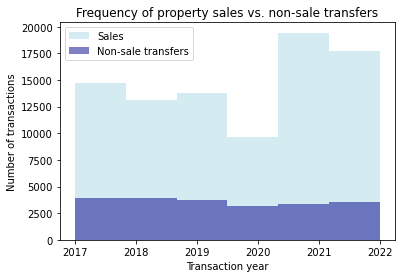

In [70]:
#FOR VIZ ONLY
#missing sale price
print("total observations: {}".format(len(sales)))
print("non-sale transfers (sale price 0): {}".format(len(sales[sales['saleprice'] == 0])))
print("sales (sale price > 0): {}".format(len(sales[sales['saleprice'] > 0])))

import matplotlib.pyplot as plt
plt.hist(sales[sales.saleprice > 0].year_sold, alpha=0.5, color='lightblue', label='Sales', bins=6)
plt.hist(sales[sales.saleprice == 0].year_sold, alpha=0.5, color='darkblue', label='Non-sale transfers', bins=6)
plt.legend()
plt.title('Frequency of property sales vs. non-sale transfers')
plt.xlabel('Transaction year')
plt.ylabel('Number of transactions')
plt.savefig('Data/OUTPUT_visualizations/1.Sales vs. non-sale transfers.png')
plt.show()

In [71]:
#SUBSET DATA
sales = sales[sales['saleprice'] > 1]

#after removing zeros
sales['log_saleprice'] = np.log(sales.saleprice)
sales = sales.drop(columns=['saleprice'])

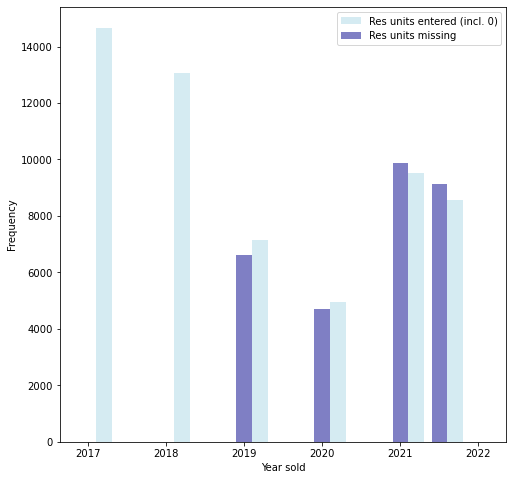

In [72]:
#FOR VIZ ONLY
#dates of missing and nonmissing residential units

a = sales[sales['units_residential']>=-1]
b = sales[sales['units_residential'].isna() == True]

plt.figure(figsize=(8,8))
plt.hist(a.year_sold+0.1, label='Res units entered (incl. 0)', color='lightblue', alpha=0.5, width=0.2)
plt.hist(b.year_sold-0.1, label='Res units missing', color='darkblue', alpha=0.5, width=0.2)
plt.xlabel('Year sold')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Data/OUTPUT_visualizations/resunitsmissing.png')
plt.show()

### PLUTO

In [73]:
pluto = pd.read_csv("Data/INPUT_pluto/pluto_22v3_1.csv", low_memory=False)
pluto.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

In [74]:
#subset to include Manhattan only
pluto = pluto[pluto['borough']=='MN']
pluto = pluto[['block',
              'lot',
               'address',
               'ltdheight',
              'splitzone',
              'histdist',
              'landmark',
              'bldgarea',
              'lotarea',
              'latitude',
              'longitude',
              'yearalter1',
              'yearalter2',
              'numbldgs',
              'numfloors']]

#rename columns for interpretability
col_mapper = {'block': 'block_pluto',
             'lot': 'lot_pluto',
             'address': 'address_pluto'}
pluto = pluto.rename(mapper=col_mapper, axis=1)

In [75]:
#create BCR variable
pluto['BCR'] = pluto['bldgarea'] / pluto['lotarea']

#create binary variables
bin_cols = ['ltdheight', 'splitzone', 'histdist', 'landmark']
pluto['bin_ltdheight'] = abs(1-(pluto.ltdheight.isna()))
pluto['bin_splitzone'] = abs(1-(pluto.splitzone.isna()))
pluto['bin_histdist'] = abs(1-(pluto.histdist.isna()))
pluto['bin_landmark'] = abs(1-(pluto.landmark.isna()))

#drop cols only used for calc
pluto = pluto.drop(columns=['bldgarea',
                           'lotarea',
                           'ltdheight',
                           'histdist',
                           'landmark',
                           'splitzone'])

#fill in None instead of 0 for yearalter1, yearalter2
tmp_list = []
for i in pluto.yearalter1:
    if i > 0:
        tmp_list.append(i)
    else:
        tmp_list.append(None)
pluto['yearalter1'] = tmp_list

tmp_list_2 = []
for i in pluto.yearalter2:
    if i > 0:
        tmp_list_2.append(i)
    else:
        tmp_list_2.append(None)
pluto['yearalter2'] = tmp_list_2

pluto.columns

Index(['block_pluto', 'lot_pluto', 'address_pluto', 'latitude', 'longitude',
       'yearalter1', 'yearalter2', 'numbldgs', 'numfloors', 'BCR',
       'bin_ltdheight', 'bin_splitzone', 'bin_histdist', 'bin_landmark'],
      dtype='object')

### Merge RSD and PLUTO

In [76]:
outlier_1 = pluto[pluto.block_pluto == pluto.block_pluto.max()]
pluto = pluto[pluto.block_pluto < pluto.block_pluto.max()]

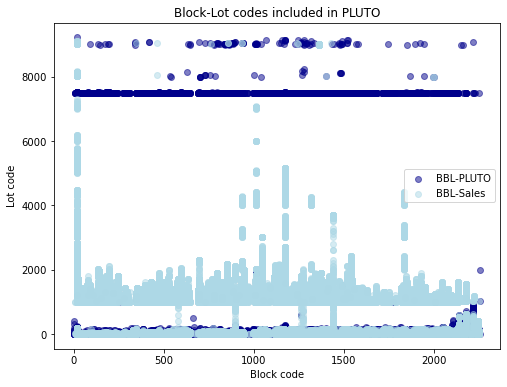

In [77]:
# Merge NYCOD and PLUTO
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(pluto.block_pluto, pluto.lot_pluto, label='BBL-PLUTO', color='darkblue', alpha=0.5)
plt.scatter(sales.block_sales, sales.lot_sales, label='BBL-Sales', color='lightblue', alpha=0.5)
plt.xlabel('Block code')
plt.ylabel('Lot code')
plt.title('Block-Lot codes included in PLUTO')
plt.legend()
plt.savefig('Data/OUTPUT_visualizations/3.Borough-Lot coverage.png')
plt.show()

In [78]:
# join based on BBL
df_1 = sales.merge(pluto, how='left', left_on=['block_sales', 'lot_sales'], right_on=['block_pluto', 'lot_pluto'])

#join based on address
#isolate transactions that were not matched before
missed = df_1[df_1['latitude'].isna() == True].iloc[:,:10]
#clean address text
addresses = []
for i in missed.address_sales:
    addresses.append(i.split(',')[0])
missed['address_clean'] = addresses
#merge on address
df_2 = missed.merge(pluto, how='left', left_on=['address_clean'], right_on=['address_pluto'])

#save out unmatched cells for later
unmatched_df = df_2[df_2.latitude.isna() == True].drop(columns=['address_clean', 'address_sales', 'address_pluto'])

#quantify
df_1 = df_1[df_1.latitude.isna() == False].drop(columns=['address_sales', 'address_pluto'])
df_2 = df_2[df_2.latitude.isna() == False].drop(columns=['address_clean', 'address_sales', 'address_pluto'])

len_all = len(sales)
len_bbl = len(df_1)
len_add = len(df_2)

print('{} total sales'.format(len_all))
print('{} matched on BBL'.format(len_bbl))
print('{} matched on address'.format(len_add))
print('{} unmatched ({:.3f}% of total)'.format((len_all - len_bbl - len_add), (100*(len_all - len_bbl - len_add)/len_all)))

#final df
df = pd.concat((df_1, df_2), axis=0)
df = df.drop(columns=['block_sales', 'lot_sales', 'block_pluto', 'lot_pluto'])
df.columns.sort_values()
#drop empty
df = df.dropna(how='all', axis=1)
df = df.dropna(how='all', axis=0)
print('shape of final df: {}'.format(df.shape))

df.to_csv('Data/OUTPUT_cleandata/df_clean.csv')

88224 total sales
43666 matched on BBL
18471 matched on address
26087 unmatched (29.569% of total)
shape of final df: (62137, 18)


In [79]:
unmatched_df = unmatched_df.drop(columns=['block_sales', 'lot_sales', 'lot_pluto', 'block_pluto'])

In [80]:
num_cols = df.select_dtypes(np.number).columns
len(num_cols)

17

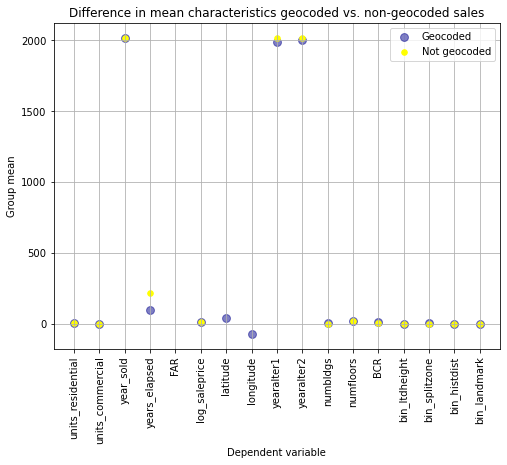

In [81]:
#FOR VIZ ONLY
#compare df and unmatched_df
num_cols = df.select_dtypes(np.number).columns
plt.figure(figsize=(8, 6))
plt.scatter(num_cols, df.describe().T['mean'], label='Geocoded', color='darkblue', s=len(df)/1000, alpha=0.5)
plt.scatter(num_cols, unmatched_df.describe().T['mean'], label='Not geocoded', color='yellow', s=len(unmatched_df)/1000)
plt.xticks(rotation=90)
plt.xlabel('Dependent variable')
plt.ylabel('Group mean')
plt.legend()
plt.grid()
plt.title('Difference in mean characteristics geocoded vs. non-geocoded sales')
plt.savefig('Data/OUTPUT_visualizations/nongeocoded.png', bbox_inches='tight')
plt.show()

### Distances

In [82]:
import pandas as pd

hospital = pd.read_csv('Data/INPUT_distances/hospital.csv')
park = pd.read_csv('Data/INPUT_distances/park.csv')
school = pd.read_csv('Data/INPUT_distances/public_school.csv')
subway = pd.read_csv('Data/INPUT_distances/subway.csv')
housing = pd.read_csv('Data/INPUT_distances/affordable_housing.csv')
college = pd.read_csv('Data/INPUT_distances/college_university.csv')
museum = pd.read_csv('Data/INPUT_distances/museum.csv')

df['dist_park'] = park.distance.values[:len(df)]
df['dist_subway'] = subway.distance.values[:len(df)]
df['dist_hospital'] = hospital.distance.values[:len(df)]
df['dist_school'] = school.distance.values[:len(df)]
df['dist_housingdev'] = housing.distance.values[:len(df)]
df['dist_college'] = college.distance.values[:len(df)]
df['dist_museum'] = museum.distance.values[:len(df)]

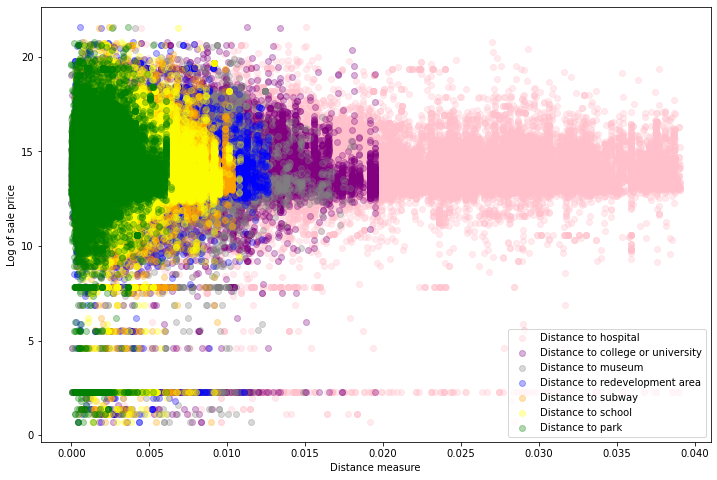

In [83]:
#FOR VIZ ONLY

#visualize distribution of each 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(df.dist_hospital, df.log_saleprice, color='pink', alpha=0.3, label='Distance to hospital')
plt.scatter(df.dist_college, df.log_saleprice, color='purple', alpha=0.3, label='Distance to college or university')
plt.scatter(df.dist_museum, df.log_saleprice, color='gray', alpha=0.3, label='Distance to museum')
plt.scatter(df.dist_housingdev, df.log_saleprice, color='blue', alpha=0.3, label='Distance to redevelopment area')
plt.scatter(df.dist_subway, df.log_saleprice, color='orange', alpha=0.3, label='Distance to subway')
plt.scatter(df.dist_school, df.log_saleprice, color='yellow', alpha=0.3, label='Distance to school')
plt.scatter(df.dist_park, df.log_saleprice, color='green', alpha=0.3, label='Distance to park')
plt.xlabel('Distance measure')
plt.ylabel('Log of sale price')
plt.legend()
plt.savefig('Data/OUTPUT_visualizations/distances.png')
plt.show()

### Macro variables

In [84]:
#NY and NJ CPI, from BLS
cpi = pd.read_csv('Data/INPUT_macro/cpi.csv').drop(columns=['Series ID', 'Label']).rename(columns={'Value':'CPI'})
months = []
for i in cpi.Period:
    months.append(int(i[-2:]))
cpi['Month'] = months
cpi = cpi.drop(columns=['Period'])

#National GDP per capita, from World Bank
gdp = pd.read_csv('Data/INPUT_macro/gdp.csv')[['2017', '2018', '2019', '2020', '2021']].T.reset_index().rename(columns={0:'GDPpcc',
                                                                                                                'index': 'Year'})
yrs_num = [int(i) for i in gdp['Year']]
gdp['Year'] = yrs_num

#Monthly Purchase-Only Indexes (Estimated using Sales Price Data) from FHFA
hpi = pd.read_csv('Data/INPUT_macro/HPI_PO_monthly_hist.csv', header=3)[['Month', 'East North Central\n(NSA)']].rename(columns={'East North Central\n(NSA)':'HPI'})
years = []
for i in hpi.Month:
    a = (str(i)[-4:])
    try:
        years.append(int(a))
    except:
        years.append(0)
months = []
for i in hpi.Month:
    a = str(i).split('/')[0]
    try:
        months.append(int(a))
    except:
        months.append(0)
hpi['Month'] = months
hpi['Year'] = years
hpi = hpi[hpi['Year'] >= 2017]
hpi = hpi[hpi['Year'] < 2023]
hpi.head()

,Month,HPI,Year
313,1,192.19,2017
314,2,194.68,2017
315,3,198.56,2017
316,4,200.77,2017
317,5,203.51,2017


In [85]:
#gdp only goes through 2021, impute 2021 values for 2022 sales

gdp = gdp.append({'Year': 2022,
                 'GDPpcc': 70248.62900}, ignore_index=True)
gdp

,Year,GDPpcc
0,2017.0,59907.75426
1,2018.0,62823.30944
2,2019.0,65120.39466
3,2020.0,63530.63348
4,2021.0,70248.62900
5,2022.0,70248.62900


In [86]:
#add tmp vars to main df
saleyrs = []
salemos = []

for i in df.saledate:
    a = str(i).split('-')
    saleyrs.append(float(a[0]))
    salemos.append(float(a[1]))
    
df['sale_yr_tmp'] = saleyrs
df['sale_mos_tmp'] = salemos

In [87]:
#merge all together
df = df.merge(cpi[['CPI', 'Month', 'Year']], how='left', left_on=['sale_mos_tmp', 'sale_yr_tmp'], right_on=['Month', 'Year'])
df = df.merge(gdp[['Year', 'GDPpcc']], how='left', left_on='sale_yr_tmp', right_on='Year')
df = df.merge(hpi[['HPI', 'Month', 'Year']], how='left', left_on=['sale_mos_tmp', 'sale_yr_tmp'], right_on=['Month', 'Year'])

df = df.drop(columns=['saledate',
                       'sale_yr_tmp',
                       'sale_mos_tmp',
                        'Month_x',
                       'Month_y',
                       'Year_x',
                       'Year_y',
                       'Year'])

## Describe final dataset

In [88]:
#check out columns with a lot of missing data
cols = pd.DataFrame(df.columns).rename(columns={0:'column_name'})
missing = []
for i in cols['column_name']:
    missing.append(100*df[i].isnull().sum()/len(df[i]))
cols['pct_missing'] = missing
to_drop = []
for i in cols.index:
    if cols['pct_missing'][i] > 90:
        to_drop.append(cols['column_name'][i])
df = df.drop(columns=to_drop)

print('Features with > 90% missing data: {} \n'.format(to_drop))
print('Features with any missing data:')
display(cols[cols['pct_missing']>0].sort_values('pct_missing', ascending=False))

Features with > 90% missing data: ['FAR', 'yearalter2'] 

Features with any missing data:


,column_name,pct_missing
9,yearalter2,93.837810
4,FAR,90.458181
1,units_commercial,58.235834
8,yearalter1,50.057132
0,units_residential,44.055877
11,numfloors,4.597905
3,years_elapsed,3.934854
12,BCR,3.603328
10,numbldgs,3.505158


In [53]:
df.describe().T.reset_index().sort_values(by='index').rename(columns={'index':'column_name'})

,column_name,count,mean,std,min,25%,50%,75%,max
20,CPI,62137.0,287.815440,15.433149,266.917000,274.478000,283.624000,297.490000,3.156560e+02
21,GDPpcc,47028.0,64957.048766,3823.962857,59907.754260,62823.309440,63530.633480,70248.629000,7.024863e+04
22,HPI,62137.0,256.602569,42.303634,192.190000,218.520000,251.620000,291.890000,3.208300e+02
5,bldgarea,62075.0,199926.975062,338290.592823,0.000000,32940.000000,107780.000000,235875.000000,8.942176e+06
18,dist_college,62137.0,0.006266,0.003799,0.000001,0.003205,0.005641,0.008870,1.946952e-02
15,dist_hospital,62137.0,0.014633,0.008621,0.000209,0.008622,0.012274,0.018683,3.906669e-02
17,dist_housingdev,62137.0,0.003039,0.002137,0.000111,0.001379,0.002769,0.004141,1.261106e-02
19,dist_museum,62137.0,0.004895,0.002905,0.000004,0.002542,0.004476,0.006992,1.804326e-02
13,dist_park,62137.0,0.001567,0.001143,0.000000,0.000629,0.001268,0.002176,6.403355e-03
16,dist_school,62137.0,0.002965,0.001739,0.000013,0.001674,0.002615,0.003837,1.084054e-02


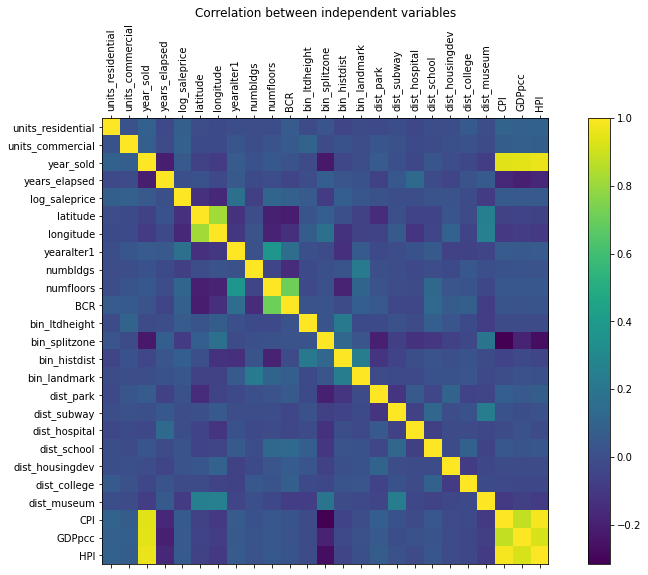

In [90]:
# plot corr matrix of all vars

f = plt.figure(figsize=(14, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation between independent variables')
plt.savefig('Data/OUTPUT_visualizations/4.Corr matrix for all vars.png', bbox_inches='tight')
plt.show()

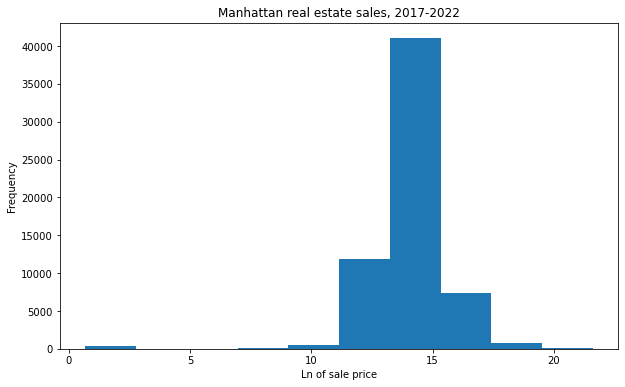

In [91]:
#plot hist of sale prices

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['log_saleprice'])
plt.xlabel('Ln of sale price')
plt.ylabel('Frequency')
plt.title('Manhattan real estate sales, 2017-2022')
plt.savefig('Data/OUTPUT_visualizations/5.Histogram of ln sale price.png', bbox_inches='tight')
plt.show()

In [92]:
df.to_csv('Data/OUTPUT_cleandata/df_dist.csv')

### Inspect outliers

In [93]:
outlier_3 = df[df.yearalter1 == df.yearalter1.min()]

In [94]:
#block mis-entered
outlier_1[['block_pluto']]

,block_pluto
783455,99999


In [95]:
#year built mis-entered
outlier_2[['address_sales', 'YEAR BUILT']]

,address_sales,YEAR BUILT
978,7 AVENUE,1111.0
979,N/A 7 AVENUE,1111.0
604,154 WEST 24TH STREET,1111.0


In [96]:
#year altered mis-entered
outlier_3[['year_sold', 'yearalter1']]

,year_sold,yearalter1
17079,2019,987.0


# Run models

In [80]:
# if reading data in from csv...
import pandas as pd
df = pd.read_csv('Data/OUTPUT_cleandata/df_dist.csv').drop(columns='Unnamed: 0')
df.head()

,units_residential,units_commercial,year_sold,years_elapsed,log_saleprice,latitude,longitude,yearalter1,numbldgs,numfloors,...,dist_park,dist_subway,dist_hospital,dist_school,dist_housingdev,dist_college,dist_museum,CPI,GDPpcc,HPI
0,11.0,0.0,2017,117.0,15.137266,40.722732,-73.977946,2017.0,1.0,5.0,...,0.000879,0.009050,0.007082,0.001207,0.000187,0.014467,0.007724,267.948,59907.75426,200.77
1,24.0,1.0,2017,107.0,15.470877,40.721552,-73.981031,NaN,2.0,5.0,...,0.000644,0.007157,0.005513,0.002245,0.001172,0.012473,0.004429,268.051,59907.75426,206.33
2,5.0,0.0,2017,117.0,15.706361,40.726569,-73.979857,1984.0,1.0,4.0,...,0.000317,0.004768,0.010503,0.001740,0.000568,0.010361,0.008657,268.051,59907.75426,206.33
3,11.0,1.0,2017,117.0,15.853479,40.724240,-73.984223,NaN,1.0,6.0,...,0.001198,0.005776,0.009023,0.001944,0.001361,0.008364,0.004690,269.381,59907.75426,205.34
4,0.0,0.0,2017,97.0,13.120361,40.720893,-73.978423,1981.0,1.0,6.0,...,0.000262,0.009351,0.005194,0.001071,0.000323,0.015058,0.006714,267.582,59907.75426,198.56


,units_residential,units_commercial,year_sold,years_elapsed,log_saleprice,latitude,longitude,yearalter1,numbldgs,numfloors,...,dist_park,dist_subway,dist_hospital,dist_school,dist_housingdev,dist_college,dist_museum,CPI,GDPpcc,HPI
0,11.0,0.0,2017,117.0,15.137266,40.722732,-73.977946,2017.0,1.0,5.0,...,0.000879,0.009050,0.007082,0.001207,0.000187,0.014467,0.007724,267.948,59907.75426,200.77
1,24.0,1.0,2017,107.0,15.470877,40.721552,-73.981031,NaN,2.0,5.0,...,0.000644,0.007157,0.005513,0.002245,0.001172,0.012473,0.004429,268.051,59907.75426,206.33
2,5.0,0.0,2017,117.0,15.706361,40.726569,-73.979857,1984.0,1.0,4.0,...,0.000317,0.004768,0.010503,0.001740,0.000568,0.010361,0.008657,268.051,59907.75426,206.33
3,11.0,1.0,2017,117.0,15.853479,40.724240,-73.984223,NaN,1.0,6.0,...,0.001198,0.005776,0.009023,0.001944,0.001361,0.008364,0.004690,269.381,59907.75426,205.34
4,0.0,0.0,2017,97.0,13.120361,40.720893,-73.978423,1981.0,1.0,6.0,...,0.000262,0.009351,0.005194,0.001071,0.000323,0.015058,0.006714,267.582,59907.75426,198.56


In [97]:
for i in df.columns:
    print('% missing for {}'.format(i))
    print(len(df[df[i].isna() == True])/len(df[i])*100)

% missing for units_residential
44.05587653089142
% missing for units_commercial
58.23583372225888
% missing for year_sold
0.0
% missing for years_elapsed
3.9348536298823564
% missing for log_saleprice
0.0
% missing for latitude
0.0
% missing for longitude
0.0
% missing for yearalter1
50.05713182161997
% missing for numbldgs
3.5051579574166762
% missing for numfloors
4.597904630091572
% missing for BCR
3.603328129777749
% missing for bin_ltdheight
0.0
% missing for bin_splitzone
0.0
% missing for bin_histdist
0.0
% missing for bin_landmark
0.0
% missing for dist_park
0.0
% missing for dist_subway
0.0
% missing for dist_hospital
0.0
% missing for dist_school
0.0
% missing for dist_housingdev
0.0
% missing for dist_college
0.0
% missing for dist_museum
0.0
% missing for CPI
0.0
% missing for GDPpcc
0.0
% missing for HPI
0.0


In [98]:
#train test split

#sort values by date
df = df.sort_values('year_sold')

# drop sale price

#subset into X and y
X = df.drop('log_saleprice', axis=1)
y = df['log_saleprice']

#split into train test split
train_size = round(len(df)*0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(49710, 24)
(49710,)
(12427, 24)
(12427,)


## RF, all vars

In [99]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

numeric_features_full = X_train.select_dtypes([np.number]).columns.tolist()
categorical_features_full = X_train.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor_full_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_full),
        ('cat', categorical_transformer, categorical_features_full)])

preprocess_full_rf = preprocessor_full_rf.fit(X_train) 

def preprocessor_full_rf(data):
    preprocessed_data = preprocess_full_rf.transform(data)
    return preprocessed_data

In [100]:
## Random Forest for feat. selection

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70],
              'n_estimators': [10, 20, 30, 40, 50, 60, 70]}

grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, scoring='r2', cv=10)

grid.fit(preprocessor_full_rf(X_train), y_train)

print("best median cross-val score: {}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {}".format(grid.score(preprocessor_full_rf(X_test), y_test)))

best median cross-val score: 0.20306525639711479
best parameters: {'max_depth': 10, 'n_estimators': 60}
test-set score: 0.17540632896950958


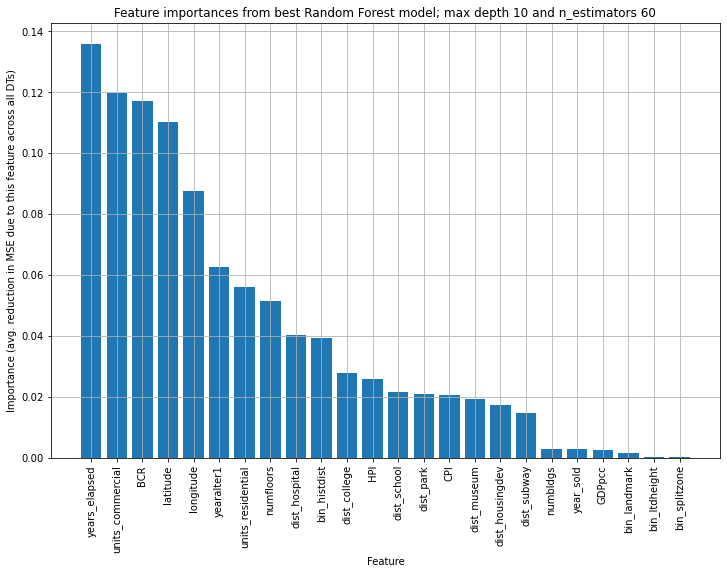

In [101]:
import matplotlib.pyplot as plt
best_forest = RandomForestRegressor(max_depth = grid.best_params_['max_depth'], n_estimators=grid.best_params_['n_estimators']).fit(preprocessor_full_rf(X_train), y_train)

forest_1_predictions = best_forest.predict(preprocessor_full_rf(X_test))

feature_names = X_train.columns
forest_importances = pd.DataFrame(best_forest.feature_importances_, index=feature_names).sort_values([0], ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(forest_importances.index, forest_importances[0])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance (avg. reduction in MSE due to this feature across all DTs)')
plt.title('Feature importances from best Random Forest model; max depth {} and n_estimators {}'.format(
    grid.best_params_['max_depth'], grid.best_params_['n_estimators']))
plt.grid()
plt.savefig('Models/featureimportances.png', bbox_inches='tight')
plt.show()

In [102]:
most_imp_cols = forest_importances.index[:10]

X_train_imp = X_train[most_imp_cols]
X_test_imp = X_test[most_imp_cols]

## RF, subset

In [103]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features_sub = X_train_imp.select_dtypes([np.number]).columns.tolist()
categorical_features_sub = X_train_imp.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

preprocessor_sub_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_sub),
        ('cat', categorical_transformer, categorical_features_sub)])

preprocess_sub_rf = preprocessor_sub_rf.fit(X_train_imp) 

def preprocessor_sub_rf(data):
    preprocessed_data = preprocess_sub_rf.transform(data)
    return preprocessed_data

In [88]:
param_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70],
              'n_estimators': [10, 20, 30, 40, 50, 60, 70]}

grid = GridSearchCV(RandomForestRegressor(), param_grid = param_grid, scoring='r2', cv=10)

grid.fit(preprocessor_sub_rf(X_train_imp), y_train)

print("best median cross-val score: {}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {}".format(grid.score(preprocessor_sub_rf(X_test), y_test)))

best median cross-val score: 0.22127373627559405
best parameters: {'max_depth': 10, 'n_estimators': 70}
test-set score: 0.2146074526721996
best median cross-val score: 0.22127373627559405
best parameters: {'max_depth': 10, 'n_estimators': 70}
test-set score: 0.2146074526721996


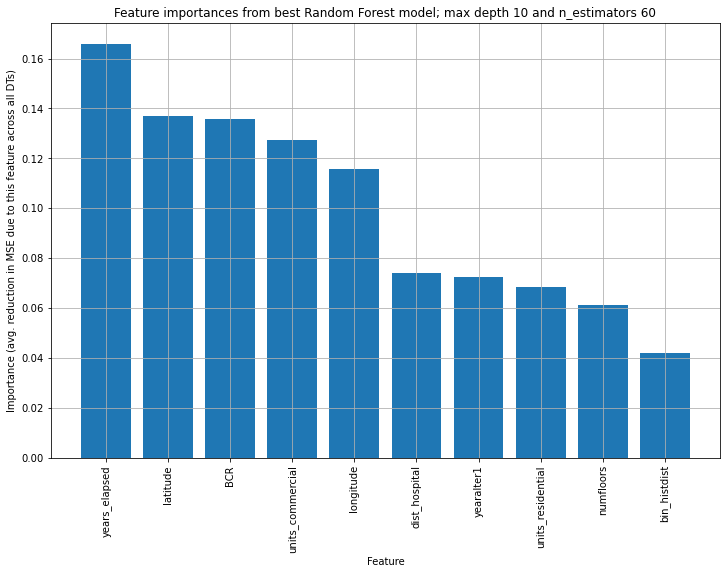

In [105]:
import matplotlib.pyplot as plt
best_forest = RandomForestRegressor(max_depth = grid.best_params_['max_depth'], n_estimators=grid.best_params_['n_estimators']).fit(preprocessor_sub_rf(X_train), y_train)

feature_names = X_train_imp.columns
forest_importances = pd.DataFrame(best_forest.feature_importances_, index=feature_names).sort_values([0], ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(forest_importances.index, forest_importances[0])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance (avg. reduction in MSE due to this feature across all DTs)')
plt.title('Feature importances from best Random Forest model; max depth {} and n_estimators {}'.format(
    grid.best_params_['max_depth'], grid.best_params_['n_estimators']))
plt.grid()
plt.savefig('Models/subfeatureimportances.png', bbox_inches='tight')
plt.show()

## OLS, all vars

In [106]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
import numpy as np

numeric_features_full = X_train.select_dtypes([np.number]).columns.tolist()

categorical_features_full = X_train.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_full_ols = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_full),
        ('cat', categorical_transformer, categorical_features_full)])

preprocessor_full_lr = preprocessor_full_ols.fit(X_train) 

def preprocessor_full_ols(data):
    preprocessed_data = preprocessor_full_lr.transform(data)
    return preprocessed_data

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(preprocessor_full_ols(X_train), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor_full_ols(X_train), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor_full_ols(X_train), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor_full_ols(X_test), y_test)))

ols_1_predictions = lr.predict(preprocessor_full_ols(X_test))

#sort results by coefficient size
ols_1_results = pd.concat((pd.DataFrame(X_train.columns), pd.DataFrame(lr.coef_)), axis=1)
ols_1_results.columns = ['column', 'coef']
ols_1_results = ols_1_results.sort_values('coef', ascending=False, key=abs)
ols_1_results

Train set score: 0.07899
Mean cross-val score for train set: 0.01638
Test set score: 0.00254.


,column,coef
5,longitude,-0.181530
0,units_residential,0.174272
8,numfloors,0.171786
6,yearalter1,0.132110
12,bin_histdist,0.131819
21,CPI,0.117904
1,units_commercial,0.103510
7,numbldgs,-0.102675
2,year_sold,-0.099133
10,bin_ltdheight,0.067203


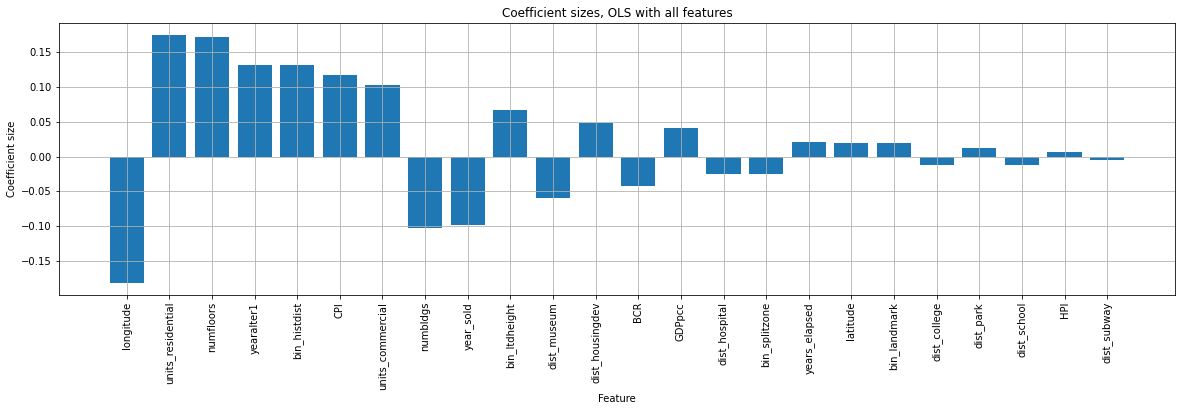

In [123]:
#OLS 1 COEFS
#plot figure
plt.figure(figsize=(20, 5))
plt.bar(ols_1_results.column, ols_1_results.coef)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Feature")
plt.ylabel('Coefficient size')
plt.title('Coefficient sizes, OLS with all features')
plt.savefig("Models/fullolscoefs.png", bbox_inches='tight')
plt.show()

## OLS, subset

In [108]:
numeric_features_sub = X_train_imp.select_dtypes([np.number]).columns.tolist()
categorical_features_sub = X_train_imp.select_dtypes([object]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess_sub_ols = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_sub),
        ('cat', categorical_transformer, categorical_features_sub)])

preprocess_sub_lr = preprocess_sub_ols.fit(X_train_imp) 

def preprocessor_sub_ols(data):
    preprocessed_data = preprocess_sub_lr.transform(data)
    return preprocessed_data

In [109]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.metrics import mean_squared_error

lr = LinearRegression().fit(preprocessor_sub_ols(X_train_imp), y_train)

print("Train set score: {:.5f}".format(lr.score(preprocessor_sub_ols(X_train_imp), y_train)))
print("Mean cross-val score for train set: {:.5f}".format(cross_val_score(lr, preprocessor_sub_ols(X_train_imp), y_train, scoring='r2').mean()))
print("Test set score: {:.5f}.".format(lr.score(preprocessor_sub_ols(X_test_imp), y_test)))

ols_2_predictions = lr.predict(preprocessor_sub_ols(X_test_imp))

#sort results by coefficient size
ols_2_results = pd.concat((pd.DataFrame(X_train_imp.columns), pd.DataFrame(lr.coef_)), axis=1)
ols_2_results.columns = ['column', 'coef']
ols_2_results = ols_2_results.sort_values('coef', ascending=False, key=abs)
ols_2_results

Train set score: 0.06673
Mean cross-val score for train set: 0.04674
Test set score: -0.00782.


,column,coef
4,longitude,-0.174519
6,units_residential,0.173487
7,numfloors,0.168846
9,bin_histdist,0.144948
5,yearalter1,0.139525
1,units_commercial,0.107449
8,dist_hospital,-0.019928
2,BCR,-0.018344
0,years_elapsed,0.006062
3,latitude,0.002971


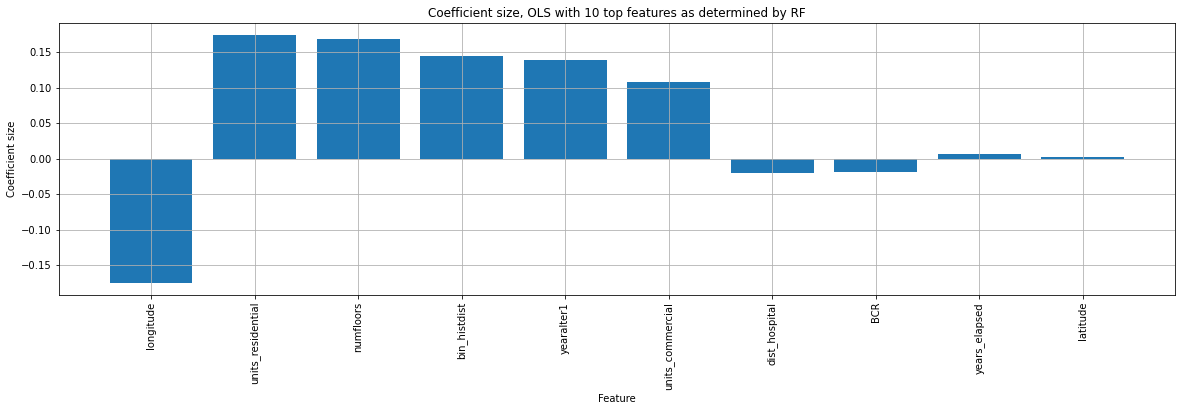

In [124]:
#plot figure
plt.figure(figsize=(20, 5))
plt.bar(ols_2_results.column, ols_2_results.coef)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Feature")
plt.ylabel('Coefficient size')
plt.title('Coefficient size, OLS with 10 top features as determined by RF')
plt.savefig("Models/subsetcoefs.png", bbox_inches='tight')
plt.show()

## Model evaluation metrics & comparison

In [117]:
res_tmp = pd.DataFrame(
    {'y_test': y_test,
     'for_1': forest_1_predictions,
     'for_2': forest_2_predictions,
     'ols_1': ols_1_predictions,
     'ols_2': ols_2_predictions
    })

results = pd.DataFrame()
results['Model'] = ['RF, all features', 'RF, 10 features', 'OLS, all features', 'OLS, 10 features']
results = results.set_index('Model')

In [118]:
#R2
from sklearn.metrics import r2_score
results['R-squared'] = [r2_score(y_test, forest_1_predictions), 
                  r2_score(y_test, forest_2_predictions), 
                  r2_score(y_test, ols_1_predictions), 
                  r2_score(y_test, ols_2_predictions)]

#mape
def mape_in_res_tmp(col_to_calc):
    lst_tmp = (res_tmp[col_to_calc] - res_tmp.y_test)/res_tmp.y_test
    sum_lst_tmp = sum(lst_tmp)
    mape = 100/len(lst_tmp)*sum_lst_tmp
    return mape
results['MAPE'] = [mape_in_res_tmp('for_1'), 
                   mape_in_res_tmp('for_2'),
                   mape_in_res_tmp('ols_1'),
                   mape_in_res_tmp('ols_2')]

#coef of dispersion
def cod_in_res_tmp(col_to_calc):
    list_of_sales_ratios = res_tmp[col_to_calc]/res_tmp.y_test
    med_sr = np.median(list_of_sales_ratios)
    in_abs_val = [abs(i-med_sr) for i in list_of_sales_ratios]
    par = sum(in_abs_val)/len(res_tmp)
    cod = 100/med_sr*par
    return cod
results['COD'] = [cod_in_res_tmp('for_1'), 
                   cod_in_res_tmp('for_2'),
                   cod_in_res_tmp('ols_1'),
                   cod_in_res_tmp('ols_2')]

results = results.round(3)
results

,R-squared,MAPE,COD
Model,,,
"RF, all features",0.192,2.522,7.100
"RF, 10 features",0.200,2.858,6.959
"OLS, all features",0.003,4.054,7.974
"OLS, 10 features",-0.008,2.182,8.327


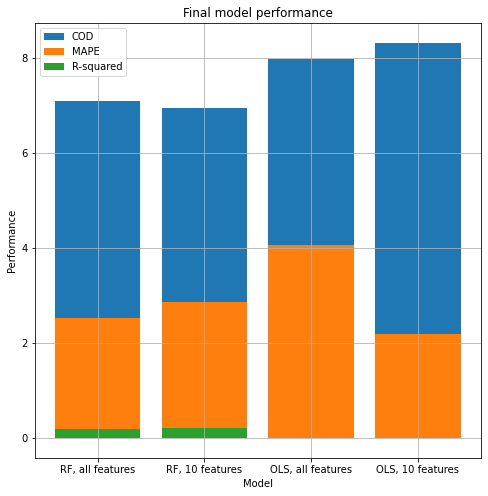

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for i in results.columns[::-1]:
    plt.bar(results.index, results[i], label=i)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Final model performance')
plt.savefig('Models/model_performance.png', bbox_inches='tight')
plt.grid()
plt.show()

In [120]:
#hit rates
hit_rates = pd.DataFrame(index=['RF, all features', 'RF, 10 features', 'OLS, all features', 'OLS, 10 features'], 
                         columns=['Within 1%', 'Within 5%', 'Within 10%', 'Within 15%', 'Within 20%'])

def predict_hit_rate(col_to_use, margin):
    in_range = []
    res_tmp['low'] = res_tmp.y_test-(res_tmp.y_test*margin)
    res_tmp['high'] = res_tmp.y_test+(res_tmp.y_test*margin)
    place = 0
    for i in res_tmp[col_to_use]:
        if i > res_tmp['low'].iloc[place]:
            if i < res_tmp['high'].iloc[place]:
                in_range.append(1)
        place =+ 1
    a = len(in_range)
    b = len(res_tmp)
    c = a/b
    return c

hit_rates['Within 1%']['RF, all features'] = predict_hit_rate('for_1', 0.01)*100
hit_rates['Within 1%']['RF, 10 features'] = predict_hit_rate('for_2', 0.01)*100
hit_rates['Within 1%']['OLS, all features'] = predict_hit_rate('ols_1', 0.01)*100
hit_rates['Within 1%']['OLS, 10 features'] = predict_hit_rate('ols_2', 0.01)*100
hit_rates['Within 5%']['RF, all features'] = predict_hit_rate('for_1', 0.05)*100
hit_rates['Within 5%']['RF, 10 features'] = predict_hit_rate('for_2', 0.05)*100
hit_rates['Within 5%']['OLS, all features'] = predict_hit_rate('ols_1', 0.05)*100
hit_rates['Within 5%']['OLS, 10 features'] = predict_hit_rate('ols_2', 0.05)*100
hit_rates['Within 10%']['RF, all features'] = predict_hit_rate('for_1', 0.10)*100
hit_rates['Within 10%']['RF, 10 features'] = predict_hit_rate('for_2', 0.10)*100
hit_rates['Within 10%']['OLS, all features'] = predict_hit_rate('ols_1', 0.10)*100
hit_rates['Within 10%']['OLS, 10 features'] = predict_hit_rate('ols_2', 0.10)*100
hit_rates['Within 15%']['RF, all features'] = predict_hit_rate('for_1', 0.15)*100
hit_rates['Within 15%']['RF, 10 features'] = predict_hit_rate('for_2', 0.15)*100
hit_rates['Within 15%']['OLS, all features'] = predict_hit_rate('ols_1', 0.15)*100
hit_rates['Within 15%']['OLS, 10 features'] = predict_hit_rate('ols_2', 0.15)*100
hit_rates['Within 20%']['RF, all features'] = predict_hit_rate('for_1', 0.20)*100
hit_rates['Within 20%']['RF, 10 features'] = predict_hit_rate('for_2', 0.20)*100
hit_rates['Within 20%']['OLS, all features'] = predict_hit_rate('ols_1', 0.20)*100
hit_rates['Within 20%']['OLS, 10 features'] = predict_hit_rate('ols_2', 0.20)*100

hit_rates.astype(float).round(3)

,Within 1%,Within 5%,Within 10%,Within 15%,Within 20%
"RF, all features",9.930,58.413,69.623,95.083,97.811
"RF, 10 features",12.167,59.717,71.176,95.019,97.868
"OLS, all features",1.368,33.813,92.227,98.865,99.026
"OLS, 10 features",5.045,62.284,98.495,98.954,99.026


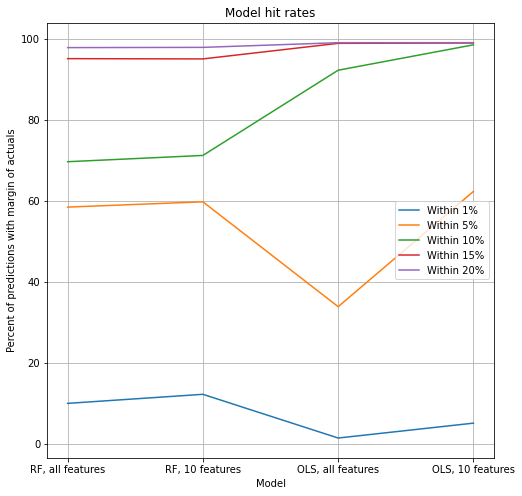

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in hit_rates.columns:
    plt.plot(hit_rates.index, hit_rates[i], label=i)
plt.legend()
plt.xlabel('Model')
plt.ylabel('Percent of predictions with margin of actuals')
plt.title('Model hit rates')
plt.savefig('Models/hit_rates.png')
plt.grid()
plt.show()

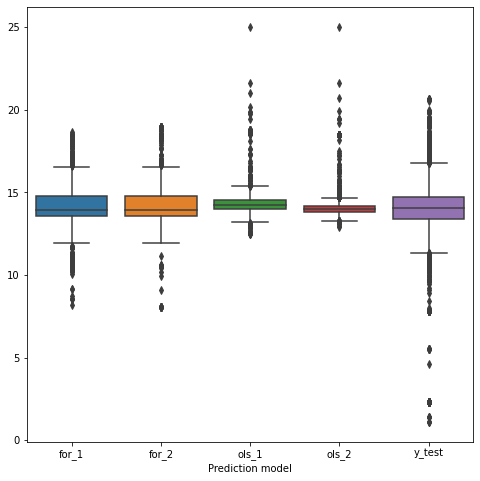

In [122]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.boxplot(data=res_tmp[['for_1', 'for_2', 'ols_1', 'ols_2', 'y_test']])
plt.xlabel('Prediction model')
plt.savefig('Models/boxplotofresults.png')
plt.show()